In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from lifelines import CoxPHFitter
import shap
import xgboost
import matplotlib.pyplot as plt
import statistics as st
from bayes_opt import BayesianOptimization
from pyirr import intraclass_correlation
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from feature_utils.feature_classfication import data_normalization, data_normalization_apply_cohort1_to_all, lgb_evaluate_lgbm, lgb_evaluate_svm

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from functools import partial
from sklearn.preprocessing import label_binarize

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, auc
import sys
import argparse

import csv
import os


/var/folders/nj/6hcc0q8x30x74w9dhvw1xz2r0000gn/T/ipykernel_43462/3540700276.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def extract_features_and_params(file_path):
    """
    提取特征列表和参数字典列表。
    
    :param file_path: txt文件的路径
    :return: features_from_file - 特征列表
             params_from_file - 参数字典列表
    """
    import ast

    with open(file_path, 'r') as file:
        content = file.readlines()
        

    # 提取特征列表
    features_from_file = ast.literal_eval(content[1].strip())
    
    # 提取参数字典
    params_content = []
    params_flag = False
    for line in content:
        if '--Params--' in line:
            params_flag = True
            continue
        if params_flag:
            if line.strip():  # 忽略空行
                params_content.append(line.strip())
                

    # 解析参数字典
    params_from_file = []
    for line in params_content:
        try:
            param_dict = ast.literal_eval(line)
            params_from_file.append(param_dict)
        except (ValueError, SyntaxError):
            continue
                
    return features_from_file, params_from_file

In [3]:
radiomics_file = '/Users/huyanshen/Desktop/AI-Medicine/Research/Shap_Value_yanshen/new_3cls_radiomics_new.txt'
radiomics_file_c4 = '/Users/huyanshen/Desktop/AI-Medicine/Research/Shap_Value_yanshen/new_3cls_radiomics_cohort4_new.txt'
result_file = '/Users/huyanshen/Desktop/AI-Medicine/Research/Shap_Value_yanshen/Age_Radio_split_age_01271312.txt'
result_file_save = '/Users/wangpengcheng/Downloads/MB_LGBM_CLNC_FINAL_3CLS/result_file_save.txt'
csv_result = '/Users/wangpengcheng/Downloads/MB_LGBM_CLNC_FINAL_3CLS/results.csv'

In [19]:
# 读取特征文件为dataframe
three_cls_path = radiomics_file
three_cls_path_c4 = radiomics_file_c4
data = pd.read_csv(three_cls_path, sep='\t')
data_c4 = pd.read_csv(three_cls_path_c4, sep='\t')

# 从txt文件中读取特征名称和模型参数
file_path = result_file
print(file_path)
sel_columns_from_file, params_from_file = extract_features_and_params(file_path)

sel_columns = sel_columns_from_file

# 参数预处理，我们使用cohort1作为训练集进行三折训练，cohort2,3,4都是作为外部测试验证集
x = data[sel_columns]
x.iloc[:, 4:] = x.iloc[:, 4:].astype(float)
print(sel_columns, x.shape)

x_new = data_c4[sel_columns]
id_new = data_c4['id'].tolist()
print(sel_columns, x_new.shape)
x_new.iloc[:, 3:] = x_new.iloc[:, 3:].astype(float)
print('total features and labels shape: ', x.shape)

# split base dataset and external validation dataset
df_val = x[(x['Cohort'] == 2) | (x['Cohort'] == 3)]
df_val.reset_index(inplace=True)
X_val = df_val.iloc[:, 4:]

feature_names = X_val.columns.tolist()
print(feature_names)
X_val_ = np.array(X_val)
y_val = df_val['Subtypes_three']
y_val = np.array(y_val)

df_new = x_new
X_new = df_new.iloc[:, 3:]

feature_names = X_new.columns.tolist()
print(feature_names)
X_new_ = np.array(X_new)
y_new = df_new['Subtypes_three']
y_new = np.array(y_new)

print('X-val: ', X_val.shape)
print('X-new: ', X_new.shape)

# 训练集
df_X = x[x['Cohort'] == 1]
df_X.reset_index(inplace=True)

folds_indices = {}

# 从文件中读取已经划分好的fold情况
for fold in df_X['fold'].unique():
    test_index = df_X[df_X['fold'] == fold].index
    train_index = df_X[df_X['fold'] != fold].index
    print(len(test_index), len(train_index))
    folds_indices[fold] = {'train_index': train_index, 'test_index': test_index}

X = df_X.iloc[:, 4:]
y = df_X['Subtypes_three']
print('X: ', X.shape)
print('Fold index has been determined!')

/Users/huyanshen/Desktop/AI-Medicine/Research/Shap_Value_yanshen/Age_Radio_split_age_01271312.txt
['Cohort', 'Subtypes_three', 'fold', 'AgeOg', 'T1E_log-sigma-3-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_x', 'T1E_log-sigma-3-mm-3D_glcm_Autocorrelation_x', 'T1E_log-sigma-1-mm-3D_glcm_ClusterShade_x', 'T1E_wavelet-LHL_firstorder_Mean_x', 'T2_wavelet-LLH_glcm_ClusterShade_y', 'T1E_log-sigma-5-mm-3D_glrlm_LowGrayLevelRunEmphasis_x', 'T1E_wavelet-HLL_firstorder_Median_x', 'T1E_wavelet-LHL_firstorder_Median_x', 'T2_wavelet-HHL_firstorder_Skewness_x', 'T1E_log-sigma-3-mm-3D_glrlm_LongRunLowGrayLevelEmphasis_x', 'T1E_lbp-2D_glrlm_RunLengthNonUniformity_x', 'T2_log-sigma-1-mm-3D_gldm_LowGrayLevelEmphasis_x', 'T1E_log-sigma-5-mm-3D_firstorder_90Percentile_x', 'T1E_log-sigma-3-mm-3D_glszm_LowGrayLevelZoneEmphasis_x', 'T2_wavelet-HHL_glcm_SumSquares_x', 'T2_wavelet-HHL_glrlm_GrayLevelNonUniformityNormalized_x', 'T2_wavelet-LLH_gldm_DependenceNonUniformity_x', 'T2_original_shape_Maximum3DDiame

In [15]:
params_best = params_from_file
        
test_folds = []
test_gt_folds = []
val_folds = []
true_folds = []
pred_folds = []
cm_folds = []
f1_test_folds = []
auc_test_folds = []
new_folds = []

for i, values in enumerate(folds_indices.values()):
    train_index, test_index = values['train_index'], values['test_index']
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    X_train = np.array(X_train)
    X_test = np.array(X_test)

    y_train = np.array(y_train).astype(int)
    y_test = np.array(y_test).astype(int)

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    X_train = np.array(X_train)
    X_test = np.array(X_test)

    y_train = np.array(y_train).astype(int)
    y_test = np.array(y_test).astype(int)

    # 这里需要注意的是采用了数据增广，所以最后用于拟合数据的训练集并不只是之前划分的X_train和y_train
    nm = SMOTE(random_state=42)
    X_res, y_res = nm.fit_resample(X_train, y_train)

    # 模型的参数以及拟合
    params_cur = params_best[i]
    modellgb = LGBMClassifier()
    modellgb.set_params(**params_cur)
    clf_lg = modellgb.fit(X_res, y_res)
    break

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3808
[LightGBM] [Info] Number of data points in the train set: 591, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [232]:
explainer = shap.Explainer(clf_lg)
shap_values = explainer(X_val)
preds = clf_lg.predict(X_val)
new_shap_values = []
print(shap_values.values.shape)

(135, 20, 3)


(135, 20)


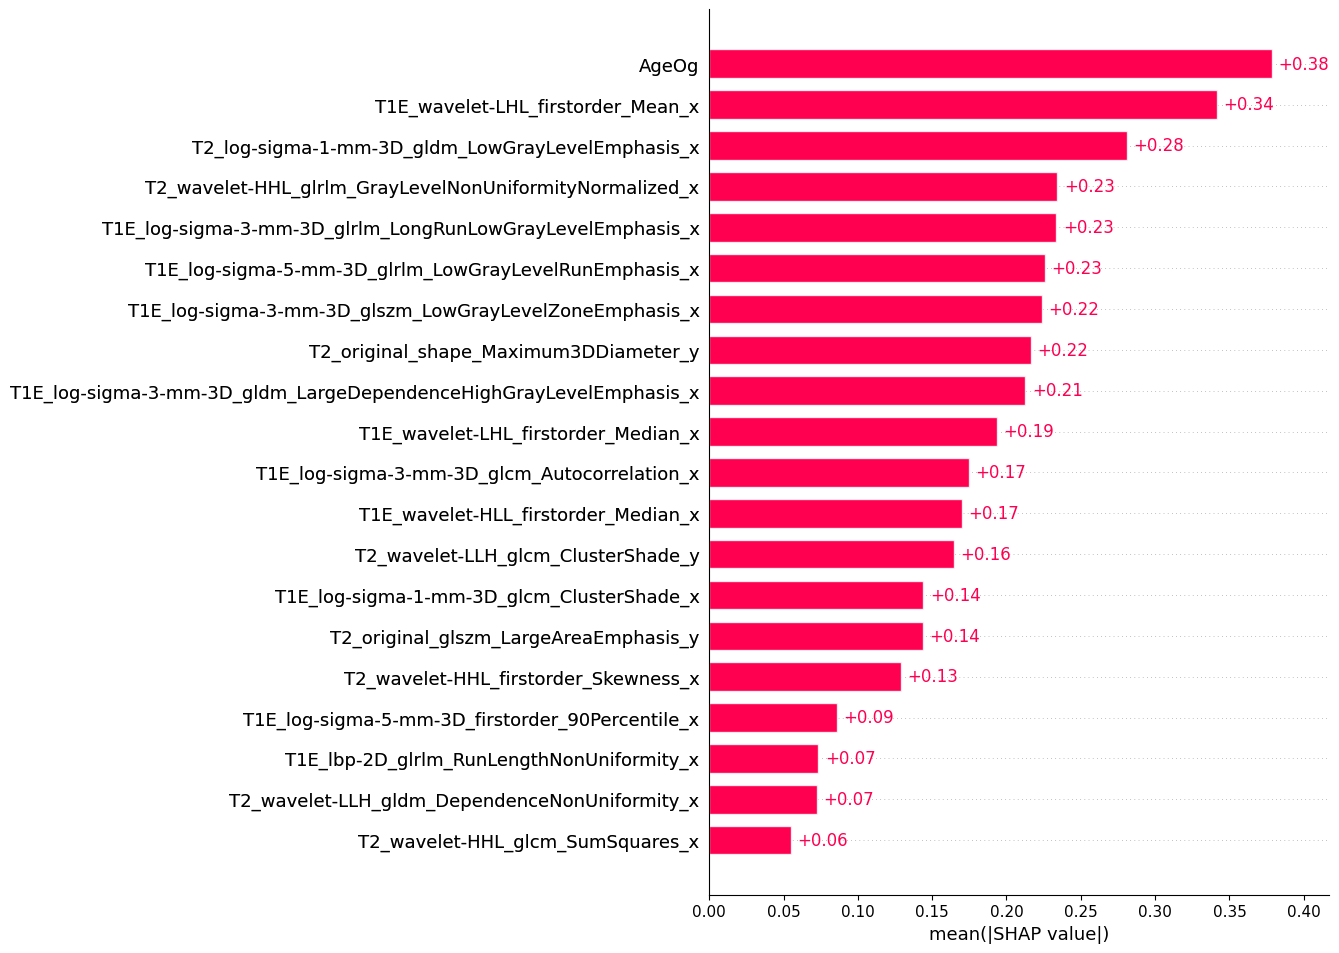

In [233]:
for i,pred in enumerate(preds):
    new_shap_values.append(shap_values.values[i][:, pred])

shap_values.values = np.array(new_shap_values)
print(shap_values.shape)    
shap.plots.bar(shap_values, max_display=20)

In [234]:
shap_dic_c23 = dict([(name, sh) for name, sh in zip(X_val.columns, abs(shap_values.values).mean(0))])
shap_dic_c23 = dict(sorted(shap_dic_c23.items(), key=lambda item: item[1],))
shap_table=pd.DataFrame.from_dict(shap_dic_c23, orient='index', columns=['Value'])
shap_table.to_csv('/Users/huyanshen/Desktop/shap.csv')
shap_table

,Value
T2_wavelet-HHL_glcm_SumSquares_x,0.055082
T2_wavelet-LLH_gldm_DependenceNonUniformity_x,0.072404
T1E_lbp-2D_glrlm_RunLengthNonUniformity_x,0.073507
T1E_log-sigma-5-mm-3D_firstorder_90Percentile_x,0.085663
T2_wavelet-HHL_firstorder_Skewness_x,0.128731
T2_original_glszm_LargeAreaEmphasis_y,0.143578
T1E_log-sigma-1-mm-3D_glcm_ClusterShade_x,0.143991
T2_wavelet-LLH_glcm_ClusterShade_y,0.164361
T1E_wavelet-HLL_firstorder_Median_x,0.170112
T1E_log-sigma-3-mm-3D_glcm_Autocorrelation_x,0.174593


In [235]:
shap_dic_c23 = dict([(name, sh) for name, sh in zip(X_val.columns, abs(shap_values.values).mean(0))])
shap_dic_c23_ = dict([(name, round(sh / sum(shap_dic_c23.values()), 3)) for name, sh in shap_dic_c23.items()])
shap_dic_c23 = shap_dic_c23_
shap_dic_c23 = dict(sorted(shap_dic_c23.items(), key=lambda item: item[1],))
shap_table=pd.DataFrame.from_dict(shap_dic_c23, orient='index', columns=['Value'])
shap_table

,Value
T2_wavelet-HHL_glcm_SumSquares_x,0.015
T2_wavelet-LLH_gldm_DependenceNonUniformity_x,0.019
T1E_lbp-2D_glrlm_RunLengthNonUniformity_x,0.020
T1E_log-sigma-5-mm-3D_firstorder_90Percentile_x,0.023
T2_wavelet-HHL_firstorder_Skewness_x,0.034
T1E_log-sigma-1-mm-3D_glcm_ClusterShade_x,0.038
T2_original_glszm_LargeAreaEmphasis_y,0.038
T2_wavelet-LLH_glcm_ClusterShade_y,0.044
T1E_wavelet-HLL_firstorder_Median_x,0.045
T1E_log-sigma-3-mm-3D_glcm_Autocorrelation_x,0.047


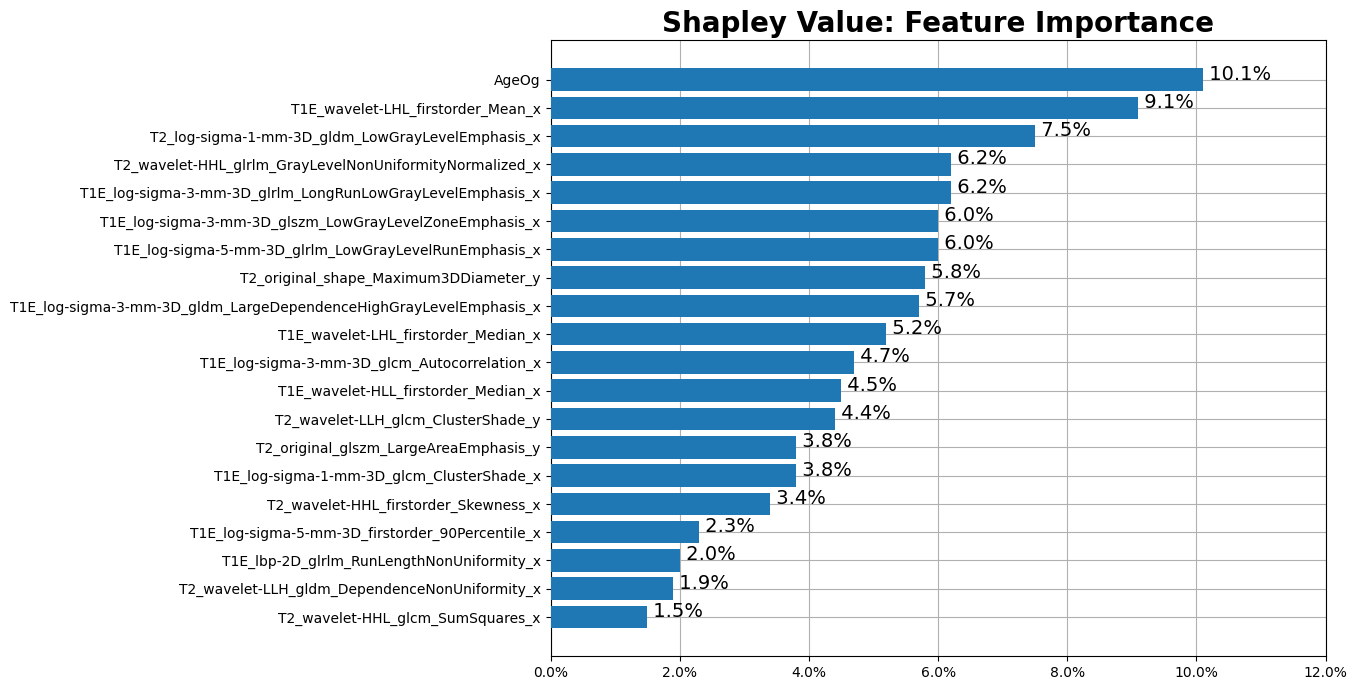

In [203]:
import matplotlib.ticker as mtick
plt.figure(figsize=(10,8))
plt.grid()
plt.title('Shapley Value: Feature Importance',fontsize=20, fontweight='semibold')
plt.xlim(0, 0.12)
bars = plt.barh(list(shap_dic_c23.keys()), list(shap_dic_c23.values()),)
for index, value in shap_dic_c23.items():
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
for bar in bars:
    bar.set_zorder(10)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))


(44, 20)


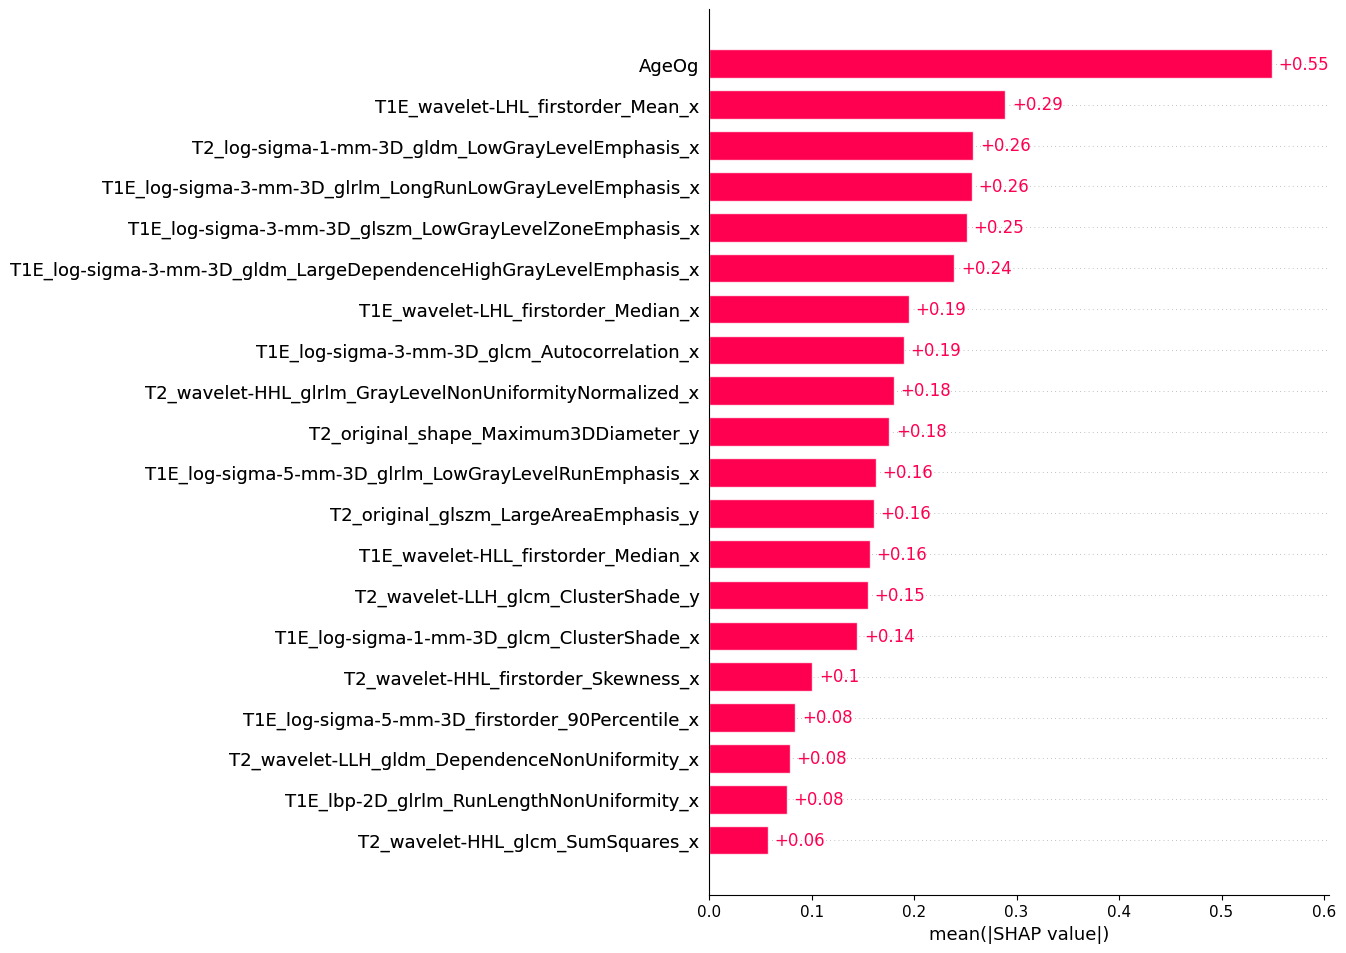

In [239]:
explainer = shap.Explainer(clf_lg)
shap_values = explainer(X_new)
preds = clf_lg.predict(X_new)
new_shap_values = []
for i,pred in enumerate(preds):
    new_shap_values.append(shap_values.values[i][:, pred])

shap_values.values = np.array(new_shap_values)
print(shap_values.shape)    
shap.plots.bar(shap_values, max_display=20)

In [240]:
shap_dic_c4 = dict([(name, sh) for name, sh in zip(X_new.columns, abs(shap_values.values).mean(0))])
shap_dic_c4 = dict(sorted(shap_dic_c4.items(), key=lambda item: item[1],))
shap_table=pd.DataFrame.from_dict(shap_dic_c4, orient='index', columns=['Shap Value Importance'])
shap_table.to_csv('/Users/huyanshen/Desktop/shap_1.csv')
shap_table

,Shap Value Importance
T2_wavelet-HHL_glcm_SumSquares_x,0.056958
T1E_lbp-2D_glrlm_RunLengthNonUniformity_x,0.075435
T2_wavelet-LLH_gldm_DependenceNonUniformity_x,0.078571
T1E_log-sigma-5-mm-3D_firstorder_90Percentile_x,0.083952
T2_wavelet-HHL_firstorder_Skewness_x,0.100555
T1E_log-sigma-1-mm-3D_glcm_ClusterShade_x,0.144694
T2_wavelet-LLH_glcm_ClusterShade_y,0.154477
T1E_wavelet-HLL_firstorder_Median_x,0.156930
T2_original_glszm_LargeAreaEmphasis_y,0.160782
T1E_log-sigma-5-mm-3D_glrlm_LowGrayLevelRunEmphasis_x,0.162737


In [241]:
shap_dic_c4 = dict([(name, sh) for name, sh in zip(X_new.columns, abs(shap_values.values).mean(0))])
shap_dic_c4_ = dict([(name, round(sh / sum(shap_dic_c4.values()), 3)) for name, sh in shap_dic_c4.items()])
shap_dic_c4 = shap_dic_c4_
shap_dic_c4 = dict(sorted(shap_dic_c4.items(), key=lambda item: item[1],))
shap_table=pd.DataFrame.from_dict(shap_dic_c4, orient='index', columns=['Value'])
shap_table

,Value
T2_wavelet-HHL_glcm_SumSquares_x,0.015
T1E_lbp-2D_glrlm_RunLengthNonUniformity_x,0.020
T2_wavelet-LLH_gldm_DependenceNonUniformity_x,0.021
T1E_log-sigma-5-mm-3D_firstorder_90Percentile_x,0.022
T2_wavelet-HHL_firstorder_Skewness_x,0.027
T1E_log-sigma-1-mm-3D_glcm_ClusterShade_x,0.039
T2_wavelet-LLH_glcm_ClusterShade_y,0.041
T1E_wavelet-HLL_firstorder_Median_x,0.042
T1E_log-sigma-5-mm-3D_glrlm_LowGrayLevelRunEmphasis_x,0.043
T2_original_glszm_LargeAreaEmphasis_y,0.043


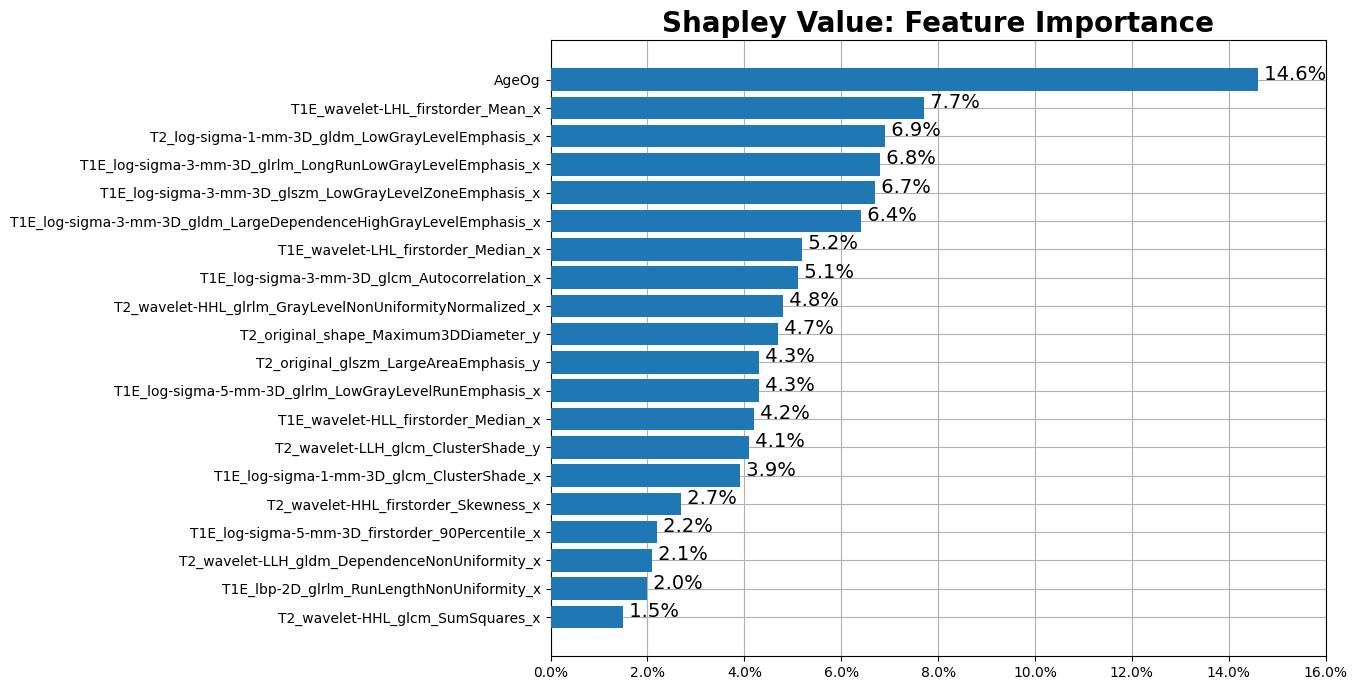

In [243]:
import matplotlib.ticker as mtick
plt.figure(figsize=(10,8))
plt.grid()
plt.title('Shapley Value: Feature Importance',fontsize=20, fontweight='semibold')
plt.xlim(0, 0.16)
bars = plt.barh(list(shap_dic_c4.keys()), list(shap_dic_c4.values()),)
for index, value in shap_dic_c4.items():
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
for bar in bars:
    bar.set_zorder(10)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))


(135, 20)


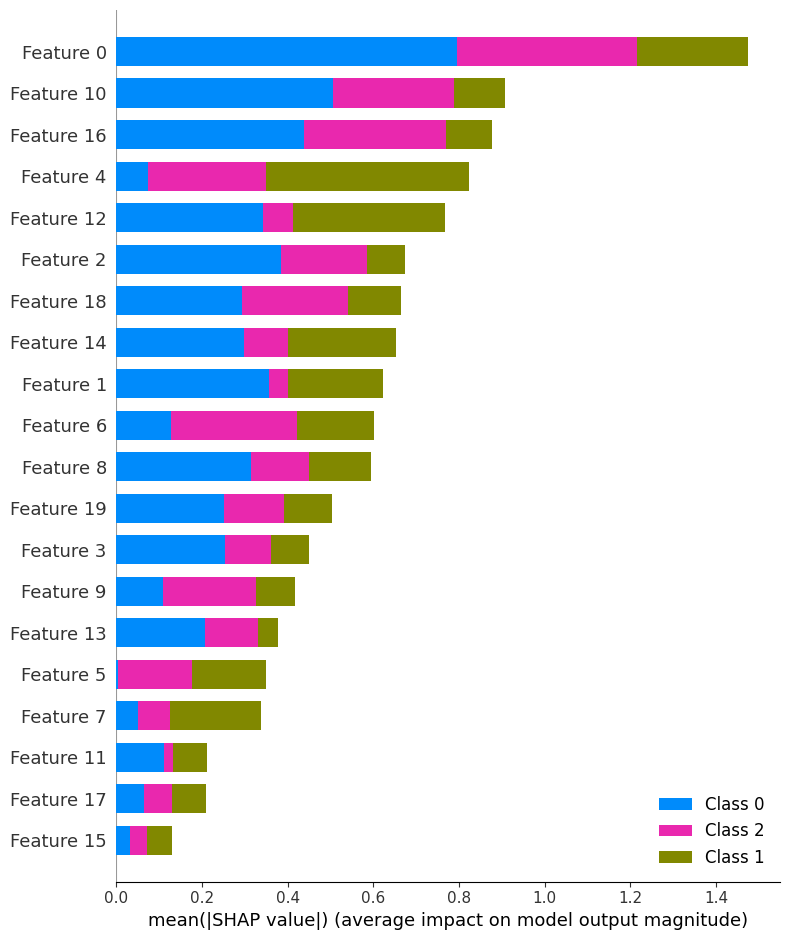

In [76]:
print(X_val.shape)
shap_values_Tree_tr = shap.TreeExplainer(clf_lg).shap_values(X_val)
shap.summary_plot(shap_values_Tree_tr, X_val)

In [38]:
print('Class0: ',shap_values_Tree_tr[0].shape,
      'Class1: ',shap_values_Tree_tr[1].shape,
      'Class2: ',shap_values_Tree_tr[2].shape)

Class0:  (135, 36) Class1:  (135, 36) Class2:  (135, 36)
